# Source Code Courtesy of Bruce Yanghy and MIT

https://github.com/BruceYanghy/End-to-End-Guide-to-Building-a-Credit-Scorecard-Using-Machine-Learning/blob/main/LICENSE

## Modified to include Hyperparameter Optimisation

In [4]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle

# 1. Data Preprocessing

In [5]:
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    #data = df[(df.order_date >= start) & (df.order_date < end)]
    data = data.reset_index(drop=True)
    #data = data.sort_values(["date", "tic"], ignore_index=True)
    #data.index = data.date.factorize()[0]
    return data


def target_info(df_target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    proportion_true=str(round(sum(df_target_column == True) / len(df_target_column), 2) * 100)
    
    proportion_false=str(round(sum(df_target_column == False) / len(df_target_column), 3) * 100)
    
    print('There are total {} records in our data.'.format(len(df_target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(df_target_column == True)))
    print('Proportion (Fraud): {}'.format(proportion_true
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(df_target_column == False)))
    print('Proportion (Not Fraud): {}'.format(proportion_false
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=df_target_column.value_counts().index, y=df_target_column.value_counts())
    plt.title('Not Fraud vs Fraud Counts')
    plt.ylabel('Count')
    return proportion_true

In [6]:
# use pandas to load the csv file
data = pd.read_csv('UCI_Credit_Card.csv')

In [7]:
# check the size of the data
data.shape

(30000, 25)

In [8]:
# check few lines
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [9]:
#use the word 'label'
data['label']=data['default.payment.next.month']
data=data.drop(columns=['default.payment.next.month'])

There are total 30000 records in our data.
Is Fraud:
Count: 6636
Proportion (Fraud): 22.0%
Not Fraud:
Count: 23364
Proportion (Not Fraud): 77.9%


'22.0'

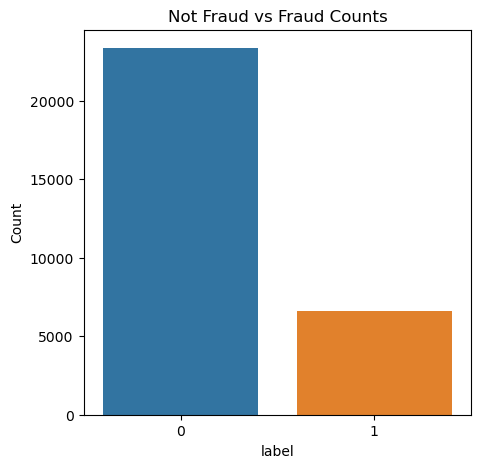

In [10]:
#check the fraud proportion of the data
target_info(data['label'])

In [11]:
# set an exclude list for the scorecard package Toad
exclude_list = ['ID','label']

In [12]:
data.ID.describe()

count    30000.000000
mean     15000.500000
std       8660.398374
min          1.000000
25%       7500.750000
50%      15000.500000
75%      22500.250000
max      30000.000000
Name: ID, dtype: float64

In [13]:
# use the ID column to split the train-test data
train = data_split(data,start = 0, end=22500,date_col='ID')
test = data_split(data,start = 22500, end=172792,date_col='ID')

In [14]:
train.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [15]:
test.label.value_counts()

label
0    5953
1    1548
Name: count, dtype: int64

# 2. Feature Selection

In [16]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the IV is smaller than the threshold, delete the features

train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'], 
                                                empty = 0.7, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True, 
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))

keep: 23 drop empty: 0 drop iv: 2 drop corr: 0


In [17]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [19]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv
df_iv=output_iv_importance(train_selected,'label')

In [20]:
df_iv.shape

(22, 2)

In [21]:
df_iv.head(30)

,name,iv
0,PAY_0,0.864707
1,PAY_2,0.536068
2,PAY_3,0.401513
3,PAY_4,0.349813
4,PAY_5,0.340014
5,PAY_6,0.282692
6,PAY_AMT1,0.189334
7,LIMIT_BAL,0.170973
8,PAY_AMT2,0.168256
9,PAY_AMT3,0.128827


# Feature Binning

Feature binning is to transform a continuous or numerical variable into a categorical feature.

It simplifies the logistic regression model and reduces the risk of model overfitting
Logistic regression is a generalized linear model, and its expressive ability is limited; Feature binning can introduce nonlinearity into the model, which can improve the expressive ability of the model and help better model fitting
The discretized features are very robust to abnormal data: for example, a feature is 1 if age > 30, and 0 otherwise. If the features are not discretized, an abnormal data point "300 years old" will impact the model fitting
It can treat null data as an individual class

In [22]:
train_selected.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [23]:
train_selected.shape

(22499, 23)

### Steps for feature binning:
#### Step 1. Initialization: c = toad.transform.Combiner() 
#### Step 2. Training binning: 
c.fit(dataframe, 
      y = 'target', 
      method = 'chi', 
      min_samples = 0.05, 
      n_bins = None, 
      empty_separate = False)
* y: target column
* method: binning method, supports chi (chi-square binning), dt (decision tree binning), kmean, quantile, step (equal step size binning)
* min_samples: Each box contains the least number of samples, which can be a number or a proportion 
* n_bins: the number of bins; If it is not possible to divide so many boxes the maximum number of bins will be divided.
* empty_separate: Whether to separate empty boxes separately 

#### Step 3. check binning nodes: c.export() 
#### Step 4. Manually adjust binning: c.load(dict) 
#### Step 5. Apply binning results: c.transform(dataframe, labels=False)
* labels: Whether to convert the binning results into box labels. If False, output 0, 1, 2… (discrete variables are sorted according to the proportion), and if True output (-inf, 0], (0,10], (10, inf).], (10, inf).

In [24]:
import time
start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

0.7055565118789673


In [25]:
combiner

In [27]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [28]:
filename

'CreditScore_save1_combiner.pkl'

In [29]:
# load the model from disk
#combiner = pickle.load(open(filename, 'rb'))

In [30]:
#output binning
bins = combiner.export()

In [31]:
len(bins)

21

In [32]:
bins

{'LIMIT_BAL': [50000.0,
  60000.0,
  80000.0,
  110000.0,
  150000.0,
  230000.0,
  370000.0],
 'EDUCATION': [2],
 'AGE': [26, 29, 34, 46],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_3': [-1, 0, 2],
 'PAY_4': [-1, 0, 1],
 'PAY_5': [-1, 0, 2],
 'PAY_6': [-1, 0, 2],
 'BILL_AMT1': [2501.0],
 'BILL_AMT2': [2400.0, 8287.0, 35213.0],
 'BILL_AMT3': [2400.0, 7458.0, 81890.0],
 'BILL_AMT4': [2501.0],
 'BILL_AMT5': [2395.0, 8110.0, 35288.0],
 'BILL_AMT6': [19195.0, 50442.0],
 'PAY_AMT1': [6.0, 4902.0],
 'PAY_AMT2': [92.0, 1603.0, 4520.0, 15002.0],
 'PAY_AMT3': [1.0, 2921.0],
 'PAY_AMT4': [1.0, 1506.0, 3946.0],
 'PAY_AMT5': [1.0, 1880.0, 10000.0],
 'PAY_AMT6': [28.0, 480.0, 926.0, 1078.0, 1501.0, 4060.0, 9567.0]}

In [33]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test[train_selected_bin.columns])

In [34]:
train_selected_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0,1,0,4,2,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,4,1,1,1,2,2,2,2,3,...,1,1,0,0,1,1,1,0,5,1
2,3,3,1,3,2,1,2,2,2,2,...,1,2,0,1,1,1,1,1,6,0
3,4,1,1,3,2,1,2,2,2,2,...,1,2,1,1,2,1,1,1,3,0
4,5,1,1,4,1,1,1,2,2,2,...,1,2,0,1,4,2,3,1,2,0


In [35]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
len(features_list)

21

C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Axes: xlabel='PAY_AMT1', ylabel='prop'>

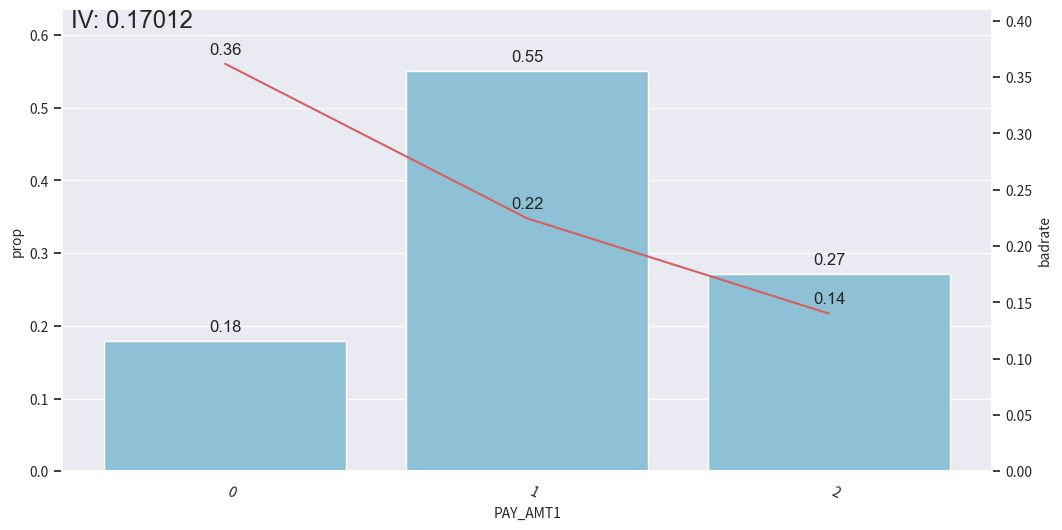

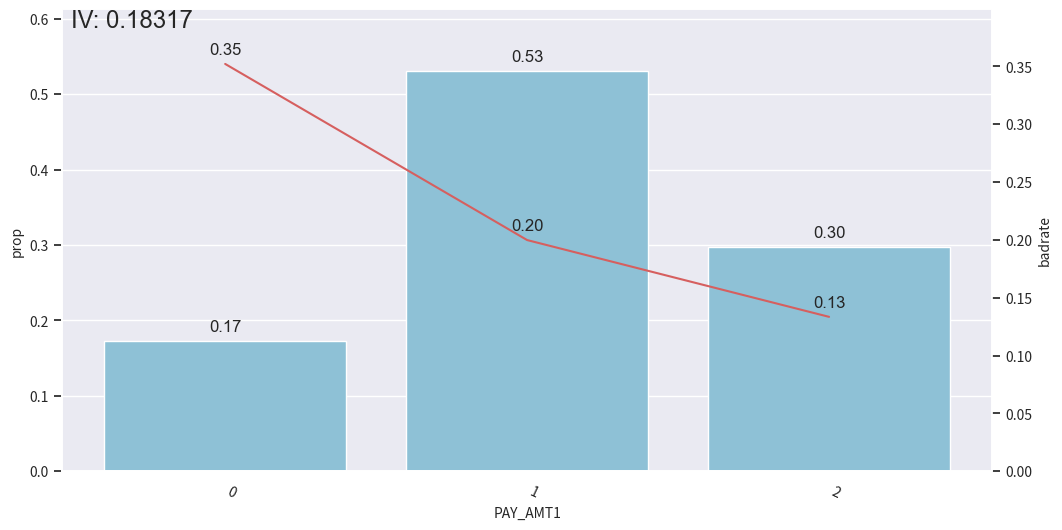

In [36]:
#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')

In [37]:
#setting rules
#rule = {'PAY_AMT1':[['0', 'nan'],['1'], ['2'], ['3']]}

#Adjust binning
#c.set_rules(rule)

In [38]:
train_selected_bin.PAY_0.describe()

count    22499.000000
mean         1.988711
std          1.038531
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: PAY_0, dtype: float64

# 4. Transform to WOE

In [39]:
##转化成WOE映射
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'], 
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

In [40]:
train_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,0.089338,0.260065,2.019269,1.459809,-0.417749,-0.383479,-0.146325,-0.117947,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.089338,-0.100163,-0.308169,1.459809,-0.296556,-0.230510,-0.203587,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.089338,0.156679,-0.308169,-0.408118,-0.417749,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0


In [41]:
final_data_woe = pd.concat([train_woe,test_woe])

In [42]:
#save 2: pickle woe_transform
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

In [43]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]

In [44]:
len(features_use)

21

## 5. Calculate PSI
* PSI (Population Stability Index) reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than 0.2

In [46]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list])
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

In [48]:
psi_df.sort_values(by='psi')

,feature,psi
1,EDUCATION,0.000258
12,BILL_AMT4,0.000330
14,BILL_AMT6,0.001591
13,BILL_AMT5,0.002520
9,BILL_AMT1,0.002634
19,PAY_AMT5,0.003066
15,PAY_AMT1,0.003402
18,PAY_AMT4,0.004556
10,BILL_AMT2,0.005398
20,PAY_AMT6,0.007230


In [49]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

In [50]:
psi_remove

[]

In [51]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
       psi025.append(i) 

In [52]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi025]
off_woe_psi = test_woe[psi025]

In [53]:
# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [54]:
print(final_data_woe.shape)

(30000, 23)


In [55]:
#save 3: final data table with transformed woe
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

# 6. Output IV

In [56]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

21

In [57]:
df_iv=output_iv_importance(final_data_woe[features_use+['label']],'label')

In [58]:
df_iv

,name,iv
0,PAY_0,0.873565
1,PAY_2,0.546857
2,PAY_3,0.412420
3,PAY_4,0.359289
4,PAY_5,0.333734
5,PAY_6,0.285164
6,LIMIT_BAL,0.181621
7,PAY_AMT1,0.173425
8,PAY_AMT2,0.162703
9,PAY_AMT3,0.114630


In [59]:
#save 4: information value after woe transformation
df_iv.to_csv('CreditScore_save4_IV.csv')

# 7. Model Training and Testing

In [71]:
from sklearn.metrics import RocCurveDisplay

def check_train_test_auc(x_train,y_train,x_test,y_test):
    # 用逻辑回归建模
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')


    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    # 预测训练和隔月的OOT
    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))
    
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

    fig, ax = plt.subplots(figsize=(12, 8))
    RocCurveDisplay.from_estimator(lr, x_test, y_test, color='blue', ax=ax)
    plt.show()
    #plot_roc_curve(lr, x_test, y_test, color='blue', ax=ax)

train KS 0.40988185783295383
train AUC 0.770323829518966
Test KS 0.4264763906414198
Test AUC 0.7834654730791719


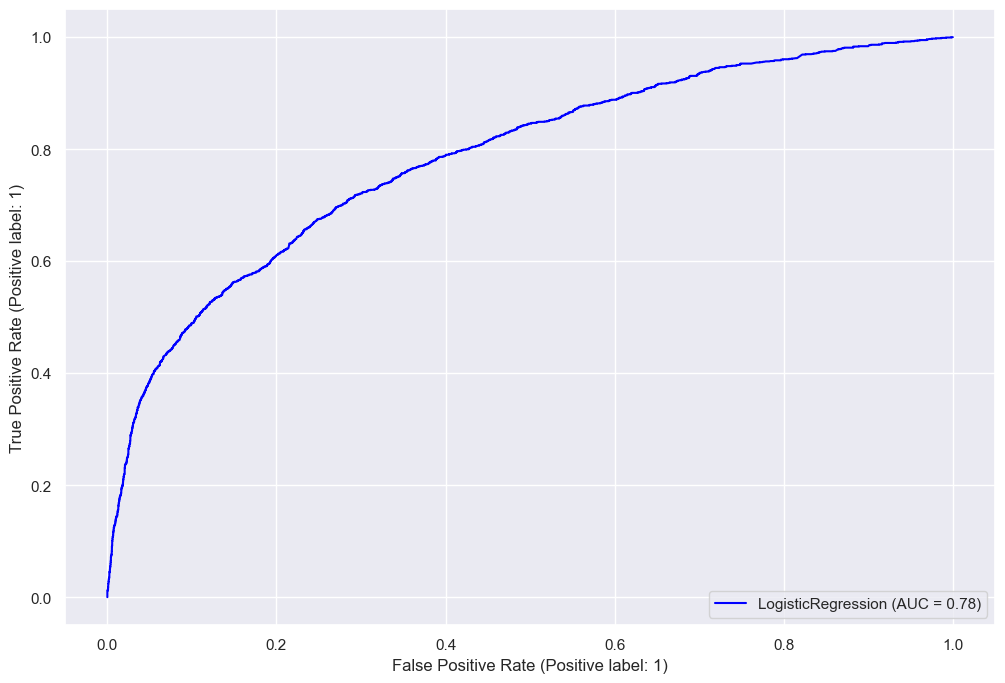

In [72]:
#train & test
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve

check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['label'],
                     x_test =test_woe[features_use] ,y_test = test_woe['label'])

# 8 Hyperparameter Optimisation
## Apply Bayesian Optimisation to identify hyperparameters for optimal performance
## Validate best model with test data

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

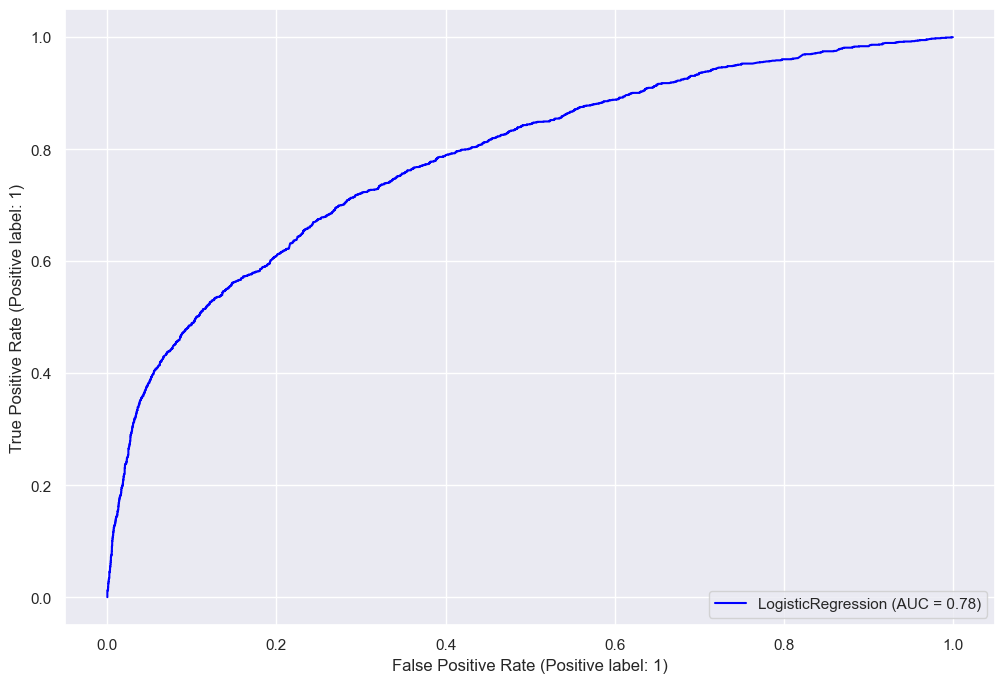

In [108]:
import numpy as np
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from toad.metrics import KS, AUC
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


x_train = train_woe[features_use]
y_train = train_woe['label']
x_test = test_woe[features_use]
y_test = test_woe['label']

# Define logistic regression model
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Define parameter search space
param_space = {
    'C': (0.01, 100.0, 'log-uniform'),  # Inverse of regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'newton-cg', 'sag', 'saga'],  # Algorithm to use in optimization
    'max_iter': (100, 5000),  # Maximum number of iterations
}

# Define custom scorers for AUC and KS
def auc_scorer_func(y_true, y_pred_proba):
    return AUC(y_pred_proba, y_true)

def ks_scorer_func(y_true, y_pred_proba):
    return KS(y_pred_proba, y_true)

auc_scorer = make_scorer(auc_scorer_func, needs_proba=True)
ks_scorer = make_scorer(ks_scorer_func, needs_proba=True)

# Perform Bayesian optimization using 5-fold cross-validation
bayes_search = BayesSearchCV(
    estimator=lr,
    search_spaces=param_space,
    scoring=auc_scorer,
    cv=5,
    n_jobs=-1,
    n_iter=50,  # Number of parameter settings that are sampled
    verbose=1,
    refit=True,
    random_state=42
)

# Fit the Bayesian search to the training data
bayes_search.fit(x_train, y_train)

# Print best hyperparameters and corresponding AUC score
print("Best Hyperparameters:", bayes_search.best_params_)
print("Best Training AUC Score:", bayes_search.best_score_)

# Evaluate on the test set using the best estimator
best_lr = bayes_search.best_estimator_
pred_test = best_lr.predict_proba(x_test)[:, 1]

# Calculate and print test AUC score
print('Test AUC', AUC(pred_test, y_test))
#test_auc = roc_auc_score(y_test, pred_test)
#print("Test AUC Score (using best estimator):", test_auc)

# Print other evaluation metrics
print('Test KS', KS(pred_test, y_test))

# Display ROC curve
fig, ax = plt.subplots(figsize=(12, 8))
RocCurveDisplay.from_estimator(best_lr, x_test, y_test, color='blue', ax=ax)
plt.show()
